In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import quandl as qd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [2]:
key = os.environ.get('Quandl_API_Key')
qd.ApiConfig.api_key = key

In [3]:
# "RATEINF/INFLATION_USA" "MULTPL/SP500_PE_RATIO_MONTH" "MULTPL/SP500_EARNINGS_MONTH"

In [4]:
today = datetime.today().date()

# get the actual day number
today_day_num = today.strftime("%d")

In [5]:
start_date = "1965-01-01"

end_date = today - timedelta(days=int(today_day_num) - 1) #Establish the end date as the first date of the current month

inflation_data = qd.get("RATEINF/INFLATION_USA", start_date = start_date, end_date = end_date)

pe_data = qd.get("MULTPL/SP500_PE_RATIO_MONTH", start_date = start_date, end_date = end_date)

In [6]:
df = pd.merge_asof(left=inflation_data, right=pe_data, right_index=True,left_index=True,direction='nearest') #Merge to the closest date since the days do not line up perfectly
df = df.rename(columns={'Value_x':'Inflation',
                        'Value_y':'S&P500_PE'})
df

,Inflation,S&P500_PE
Date,,
1965-01-31,0.971,18.71
1965-02-28,0.971,18.55
1965-03-31,1.294,18.59
1965-04-30,1.618,18.65
1965-05-31,1.618,17.57
...,...,...
2022-09-30,8.202,18.12
2022-10-31,7.745,20.14
2022-11-30,7.110,21.22


In [7]:
df.describe()

,Inflation,S&P500_PE
count,697.000000,697.000000
mean,3.987288,19.661478
std,2.867229,12.036813
min,-2.097000,6.790000
25%,2.108000,14.120000
50%,3.189000,17.950000
75%,4.979000,22.500000
max,14.756000,123.730000


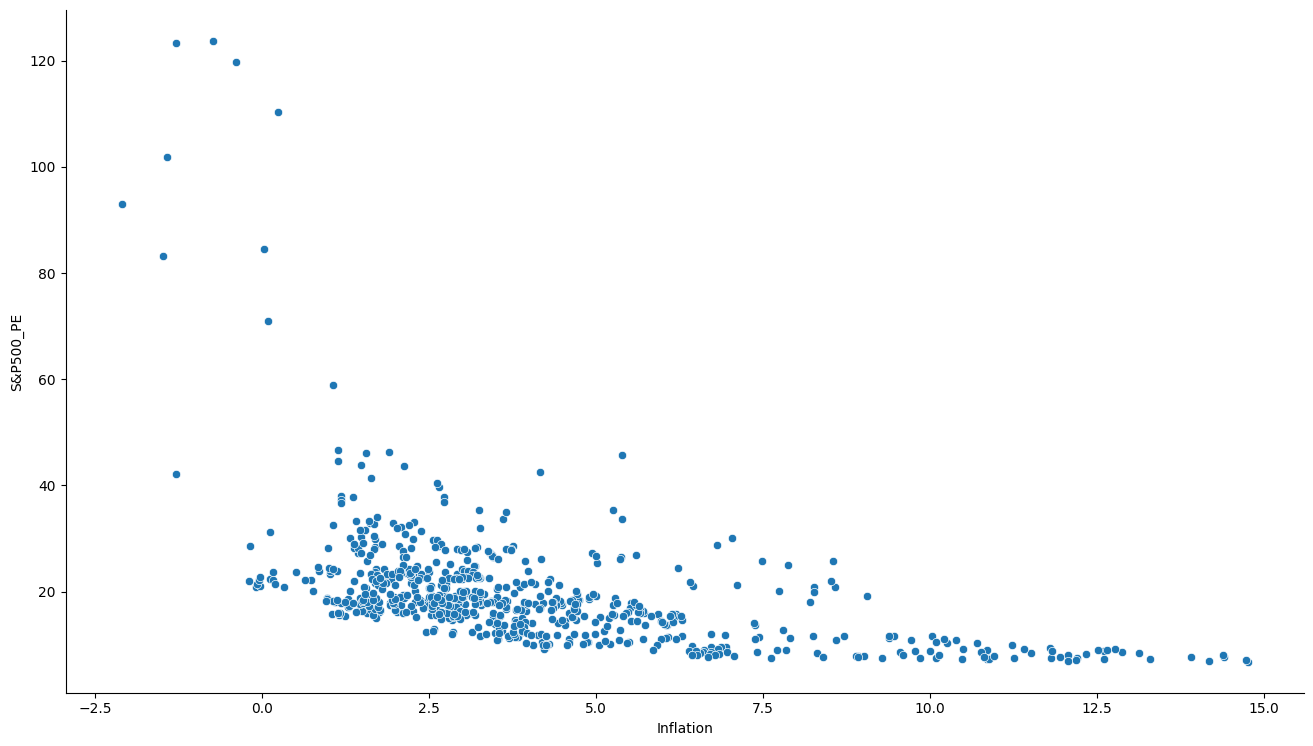

In [8]:
g = sns.relplot(x='Inflation', y='S&P500_PE', data=df)
g.fig.set_size_inches(15,8)

In [9]:
#Remove outliers in S&P 500

upper_limit = df['S&P500_PE'].quantile(0.95)

df = df[(df['S&P500_PE'] < upper_limit)]

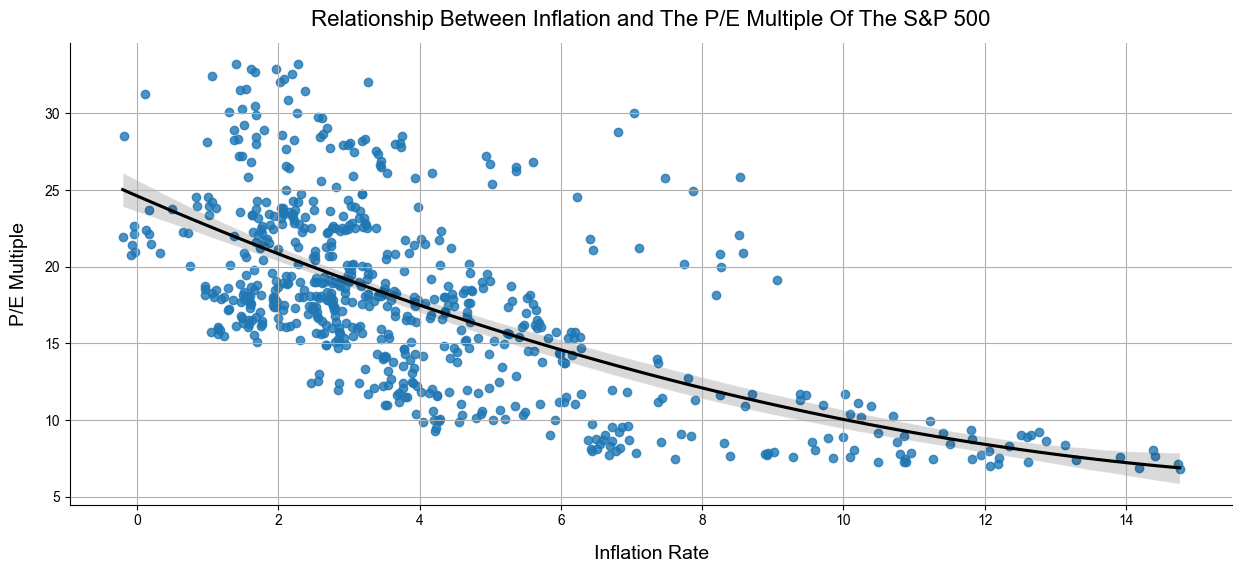

In [10]:
fig = plt.figure(figsize=(15, 6))
sns.regplot(x='Inflation', y='S&P500_PE', data=df, order = 2, line_kws={"color":"black"})
sns.set(style="ticks")
sns.despine()
plt.xlabel("Inflation Rate", fontsize= 14, labelpad =12)
plt.ylabel("P/E Multiple", fontsize= 14, labelpad =12)
plt.title("Relationship Between Inflation and The P/E Multiple Of The S&P 500", fontsize=16, pad= 12)
plt.grid();

In [11]:
X = df['Inflation']
y = df['S&P500_PE']

## Statsmodel Method

https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html

In [12]:
from sklearn.preprocessing import PolynomialFeatures
sm_poly = PolynomialFeatures(degree=2)
sm_poly_features = sm_poly.fit_transform(X.values.reshape(-1,1))

model = sm.OLS(y, sm_poly_features).fit()
ypred = model.predict(sm_poly_features) 

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              S&P500_PE   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     226.7
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           1.21e-75
Time:                        11:24:45   Log-Likelihood:                -1950.0
No. Observations:                 662   AIC:                             3906.
Df Residuals:                     659   BIC:                             3920.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.6164      0.536     45.965      0.000      23.565      25.668
x1            -1.9968      0.215     -9.301      0.000      -2.418      -1.575
x2             0.0538      0.016      3.274      0.001       0.022       0.086
==============================================================================
Omnibus:                       68.087   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.714
Skew:                           0.859   Prob(JB):                     1.48e-19
Kurtosis:                       3.442   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
print(f"The r-squared score of the model is {round(model.rsquared,2)}")

The r-squared score of the model is 0.41


In [15]:
model.params

const    24.616357
x1       -1.996831
x2        0.053844
dtype: float64

In [16]:
user_input = 6.45
test = sm_poly.fit_transform(np.array(user_input).reshape(-1,1))
new_result = round(model.predict(test)[0],2)
new_result

13.98

In [17]:
prediction_intervals = model.get_prediction(test)
intervals = prediction_intervals.summary_frame(alpha=0.05)
intervals

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,13.976836,0.310566,13.367017,14.586655,4.897421,23.05625


In [18]:
mean_pred = prediction_intervals.predicted_mean
mean_pred[0]

13.97683580352012

In [19]:
lower, upper = prediction_intervals.conf_int(alpha=0.05).T

print(lower[0])
print(upper[0])

13.367016809488154
14.586654797552084


In [20]:
conf = model.conf_int(alpha=0.05)
conf

,0,1
const,23.564787,25.667928
x1,-2.418384,-1.575278
x2,0.021551,0.086137


In [21]:
print(f"The point estimate of the user input is: {round(intervals['mean'][0],2)}")
print(f"The lower confidence interval is: {round(intervals['mean_ci_lower'][0],2)}")
print(f"The upper confidence interval is: {round(intervals['mean_ci_upper'][0],2)}")

The point estimate of the user input is: 13.98
The lower confidence interval is: 13.37
The upper confidence interval is: 14.59


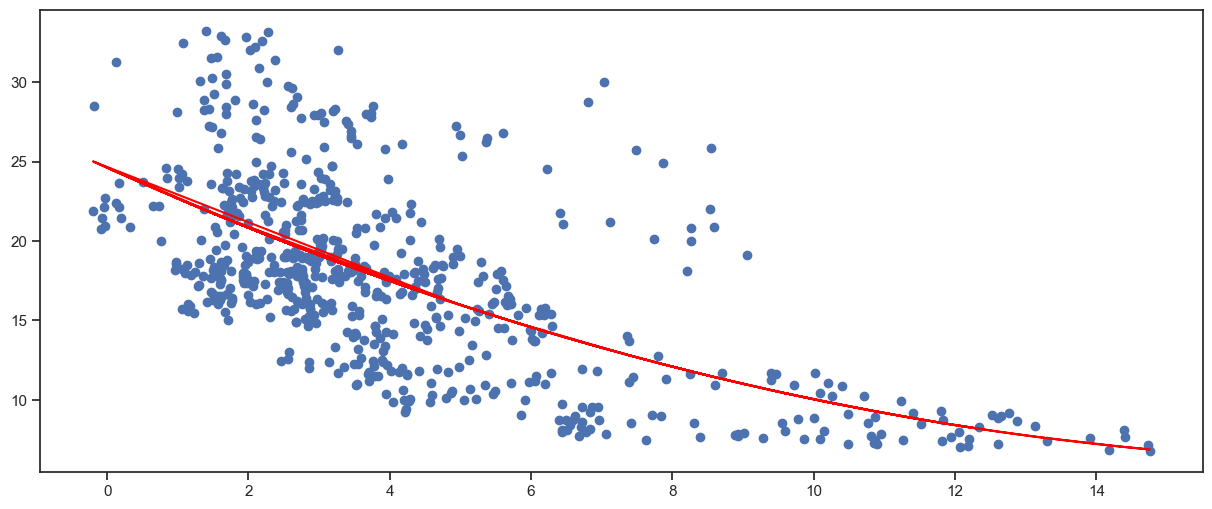

In [22]:
plt.figure(figsize=(15, 6))
plt.scatter(X, y)
plt.plot(X, ypred, c="red")
plt.show()

## Historical Earnings

In [23]:
historical_earnings = qd.get("MULTPL/SP500_EARNINGS_MONTH", start_date = start_date, end_date = end_date).pct_change(periods=12)*100
historical_earnings = historical_earnings.dropna()
historical_earnings = historical_earnings.rename(columns={'Value':'Historical_Earnings'})
historical_earnings

,Historical_Earnings
Date,
1966-01-31,11.922197
1966-02-28,11.221945
1966-03-31,11.243804
1966-04-30,10.505141
1966-05-31,10.079576
...,...
2022-05-31,20.340639
2022-06-30,11.041919
2022-07-31,6.858135


In [24]:
historical_earnings.mean()

Historical_Earnings    11.783167
dtype: float64

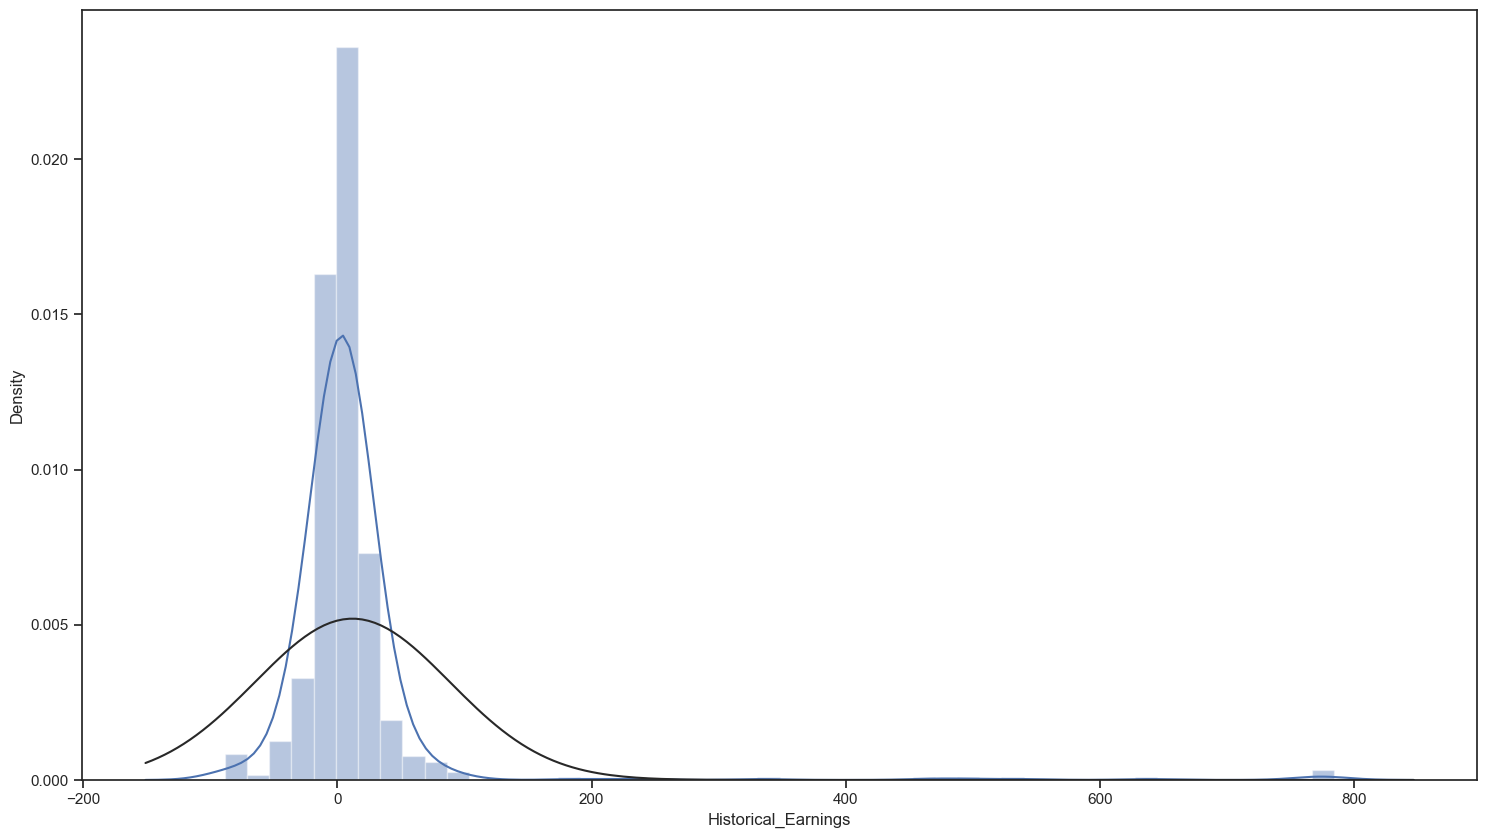

In [25]:
fig = plt.subplots(figsize=[18,10])
sns.distplot(historical_earnings['Historical_Earnings'], fit=norm);

In [26]:
from DataCleaning import OutlierRemover

outlier_remover = OutlierRemover(historical_earnings)
outlier_remover.remove_outliers_iqr('Historical_Earnings')
historical_earnings = outlier_remover.df

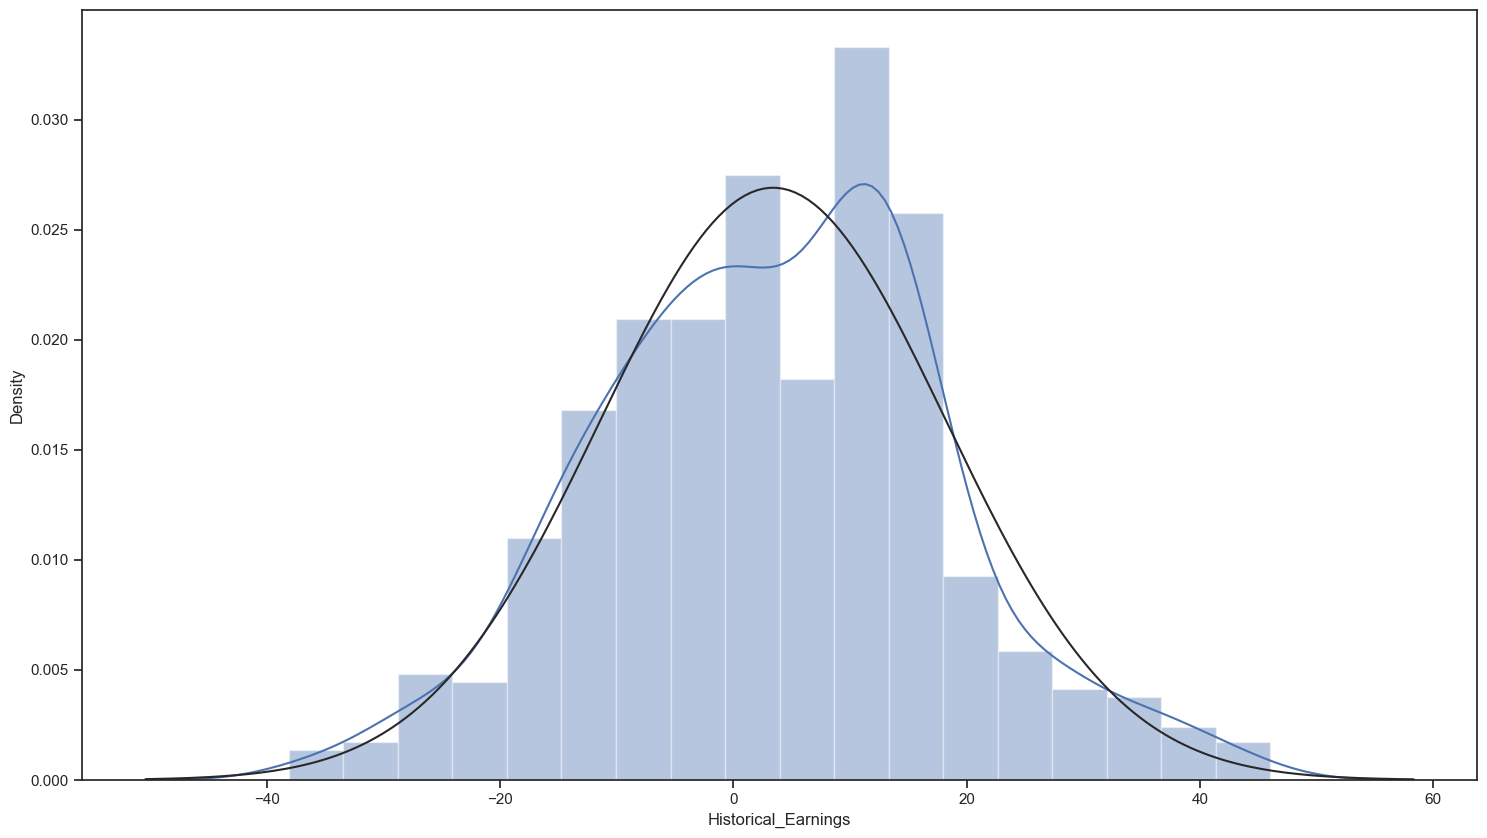

In [27]:
fig = plt.subplots(figsize=[18,10])
sns.distplot(historical_earnings['Historical_Earnings'], fit=norm);

In [28]:
#Test for normality using Shapiro-Wilk test

shapiro_test = stats.shapiro(historical_earnings['Historical_Earnings'])

if shapiro_test.pvalue <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

Null hypothesis of normality is rejected.


In [29]:
historical_earnings['Historical_Earnings'].median()

3.364987613542536

In [30]:
historical_earnings['Historical_Earnings'].quantile(0.25)

-6.808876010785287

In [31]:
historical_earnings['Historical_Earnings'].quantile(0.75)

13.215339402801273

In [32]:
historical_earnings['Historical_Earnings'].quantile(0.95)

28.034951644366412

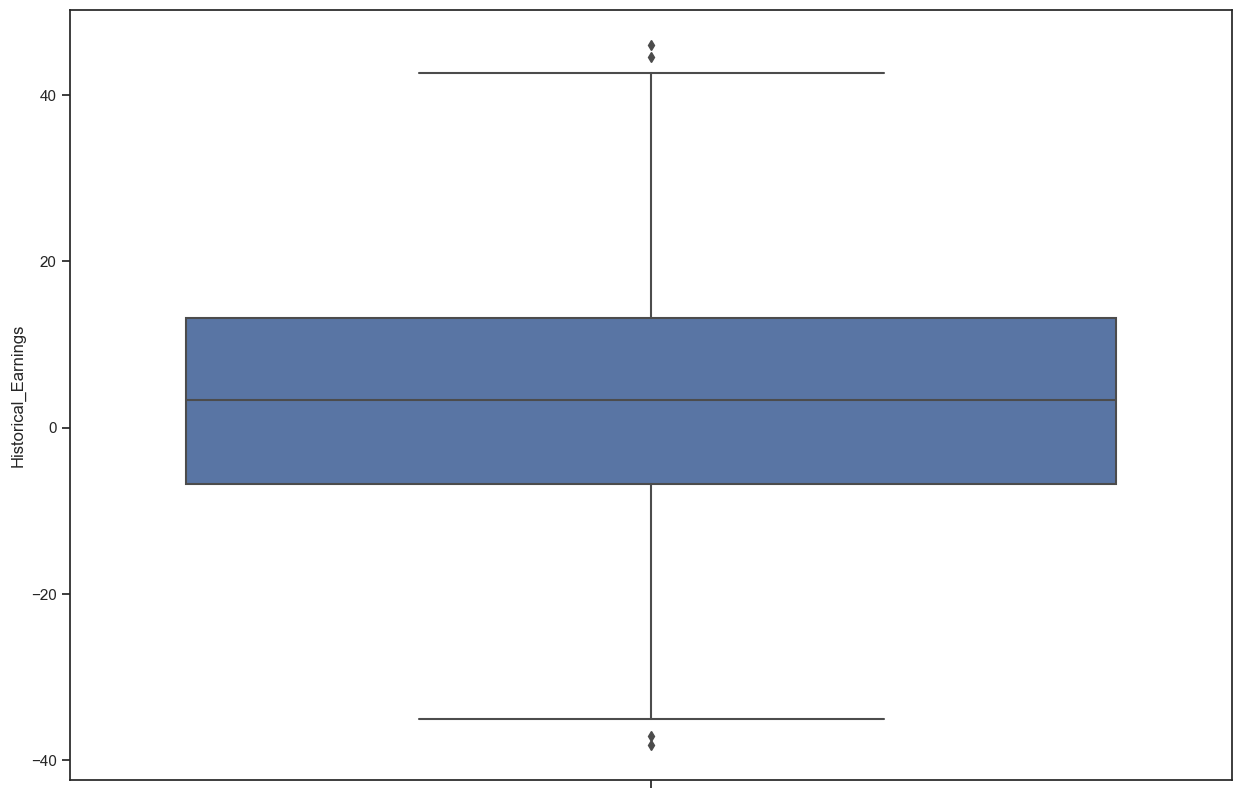

In [33]:
plt.figure(figsize=(15,10))
sns.boxplot(y= 'Historical_Earnings', data=historical_earnings);

In [34]:
def eoy_estimate(current_value,growth_rate):
    estimate = current_value * (1+round(growth_rate/100,2))
    return round(estimate,2)

eoy_estimate(187.07, historical_earnings['Historical_Earnings'].quantile(0.25))

173.98